가설검정(T-test)
- 정의: 통계값(평균)의 차이 여부 확인
- 사전 충족 조건: 정규성(각 변수, `skew, kurtosis`, `p≥0.05`), 등분산성(한번에 모든변수 비교, `p≥0.05`)
- 가설 종류: 귀무가설(Hο, `~가 없다`), 대립가성(H1, `~가 있다`)
  - in other words, Hο: `같다`, H1: `다르다(ex. 크다, 작다)`
- 검정 종류:
  - 단일표본: 모집단과 표본집단 A, `p<0.05`
  - 독립표본: 두 표본집단, `p<0.05`
  - 대응표본: 표본집단 A의 전과 후, `p<0.05`

for 데이터 분석 결과: `해석 문장 템플릿`이 정형화 되 있는 편임!

# [LAB-10] 6. 독립표본 T-Test 
# (이표본 검정, Independent two sample T-test)

- : 서로다른 두 그룹 간 평균차가 유의미한지의 여부 판단법
- 사전 조건: 데이터 정규성, 등분산성 만족 (=가설검정의 가정)

## #01. 준비작업

### 1. 패키지 참조:

`statannotations` 패키지 설치필요: 
- 설명: "오직 파이썬만 구현 가능한" `seaborn에 얹어서 쓰는 시각화 패키지` (Tableau도 표현못함)
- 기능: seaborn으로 구현한 그래프에 설명(`p-value 범위, 기호로`) 얹음
- 조건: 무조건 `melt 함수` 걸어야됨
- 제한점: for 가설검정(귀무, 대립): 귀무가설만 적용 가능

In [1]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 독립표본 가설검정용 패키지:
from scipy.stats import t, ttest_ind, normaltest, bartlett, levene
from statannotations.Annotator import Annotator

### 2. 그래프 초기화:

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

## #02. 예제(1) - 지혈제 효과 비교

### 1. 데이터 가져오기:

두 종료의 지혈제 효과를 측정한 자료이다.

실험 참가자를 두 그룹으로 임의 분할한 후 피부에 작은 상처를 내어 피가 흐르게 한 다음, 한 그룹에는 지혈제 B를 다른 그룹에는 지혈제 G를 투여하여 완전히 지혈될 때 까지의 시간(분)을 측정하였다.

목표: 지혈제에 따른 지혈시간이 유의미한 차이가 있는지 확인하라.

(단, 모든 데이터는 정규성을 충족한다고 가정한다.) -> 가설검정의 가정 확인 안해도 됨 개꿀!

In [3]:
origin = load_data('styptic')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/styptic.xlsx
[desc] 실험 참가자를 두 그룹으로 임의 분할한 후 피부에 작은 상처를 내어 피가 흐르게 한 다음, 한 그룹에는 지혈제 B를 다른 그룹에는 지혈제 G를 투여하여 완전히 지혈될 때 까지의 시간(분)을 측정한 두 종료의 지혈제 효과를 측정한 자료 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (10, 2)
열 갯수: 2
행 갯수: 10

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B       10 non-null     float64
 1   G       10 non-null     float64
dtypes: float64(2)
memory usage: 292.0 bytes
None


,B,G
0,8.8,9.9
1,8.9,10.0
2,8.4,9.0
3,7.9,11.1
4,8.2,9.8


### 2. 신뢰구간 확인:

두 그룹의 데이터분포랑 신뢰구간 확인:

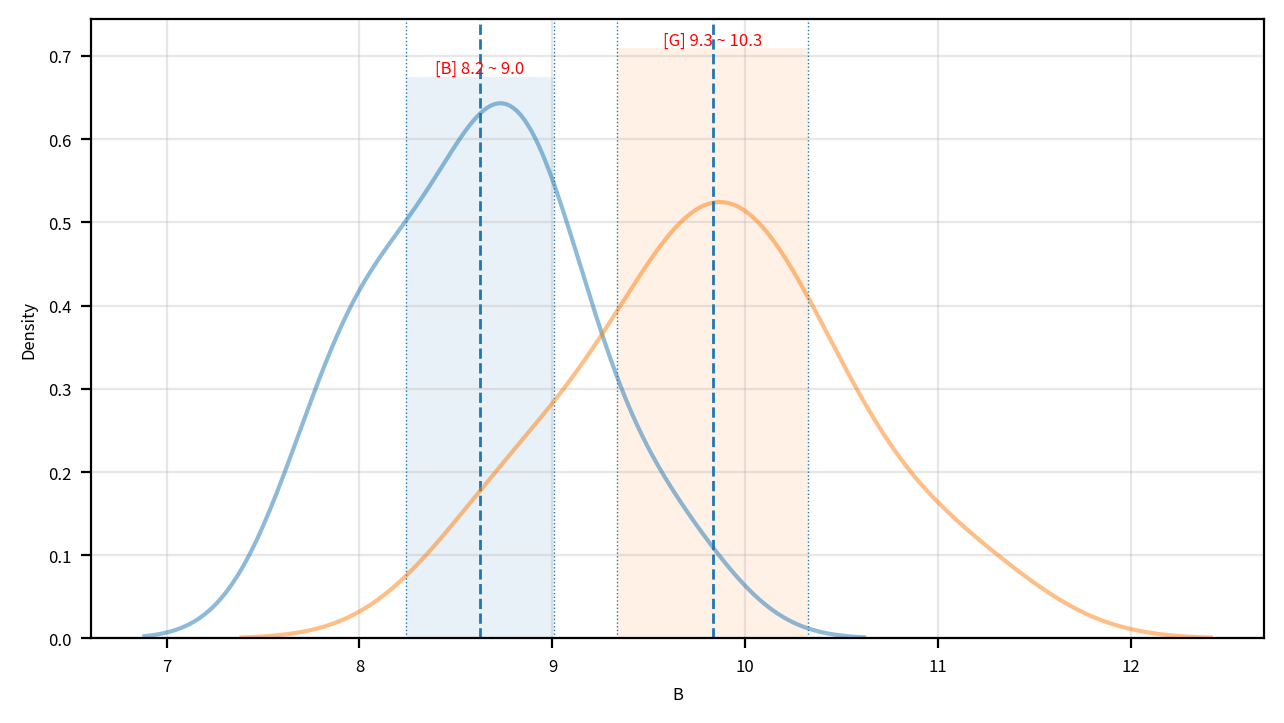

In [9]:
data = origin[['B', 'G']]   # 확인할 데이터 (컬럼단위)

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for c in data.columns:
    # 2) KDE plot 그리기:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 2-1) 신뢰구간용 기본변수:
    max = data[c].max()                        # 최대값
    dof = len(data[c]) - 1                     # 자유도
    clevel = 0.95                           # 신뢰수준
    sp_mean = data[c].mean()                   # 표본평균
    sp_std = data[c].std() # default: ddof=1   # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차

    # 2-2) 신뢰구간 x값:
    cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

    ax.axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
    ax.axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

    # 2-3) 신뢰구간 y값:
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    # 2-4) 평균선 표시:
    ax.axvline(sp_mean, linestyle="--", linewidth=1)

    # 2-5) 텍스트 그리기 (statAnnotator 기능):
    ax.text(x = cmin + (cmax-cmin)/2,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment = "center",
            verticalalignment = "bottom",
            fontdict = {"size": 6, "color": "red"})

# 3) 그래프 꾸미기: 
ax.grid(True, alpha=0.3)     # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

### 3. 가설검정의 `가정` 확인 (`정규성, 등분산성`):

In [11]:
data = origin[['B', 'G']]

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    s, p = normaltest(data[c])

    normalize = p > 0.05
    report.append({
        "fields": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

# 변수가 두개 이상일 때 확인해야될 등분산성:
if len(data.columns) > 1:
    # 정규성 충족할 때 등분산성 검정방법:
    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*data.values.T) # 모든 컬럼의 데이터 한번에
    # 정규성 충족 못할 때 등분산성 검정법:
    else:
        n = "Levene's"
        s, p = levene(*data.values.T, center='median')
        # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨
    
    report.append({
        "fields": c,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
B,0.083269,0.959221,True
G,0.200950,0.904408,True
G,0.555515,0.456073,True


> 독립표본에서의 가설검정의 가정 결과: 정규성 만족, 등분산성 만족!
>
> -> 데이터 신뢰 가능!

### 4. 두 그룹간 지혈시간 평균에 차이가 있는지 검정:

| 구분 | 수식 | 내용 |
| --- | --- | --- |
| B 그룹의 평균 | $\mu$(B) |  |
| G 그룹의 평균 | $\mu$(G) |  |
| 귀무가설($H_0$) | $\mu$(B) = $\mu$(G) | 두 그룹의 지혈시간 평균은 차이가 `없다` |
| 대립가설($H_1$) | $\mu$(B) ≠ $\mu$(G) | 두 그룹의 지혈시간 평균은 차이가 `있다` |

두 그룹 간 평균 비교를 위해선 `ttest_ind` 메서드 사용 필요
- `alternative` 파라미터에 따라 비교 내용 달라짐.
- 내용은 대립가설에 따라 결정된다:

| 값 | 설명 |
| -- | -- |
| `two-sided` | 두 그룹의 평균이 같은지 판단 (기본값) |
| `greater` | 두 그룹 중 첫번째 그룹의 평균이 더 큰지 판단 |
| `less` | 두 그룹 중 첫번째 그룹의 평균이 더 작은지 판단 |


In [12]:
# 독립표본의 t-test에선 target값 필요없음
s, p = ttest_ind(origin['B'], origin['G'])
"statistic:{0:.3f}, p-value:{1:.3f}, {2}가설 채택".format(s, p, '대립' if p<=0.05 else '귀무')

'statistic:-4.350, p-value:0.000, 대립가설 채택'

> 결론: `p-value` ≤ 0.05 이므로 지혈제 B를 사용한 그룹과 지혈제 G를 사용한 그룹 간 평균 지혈시간은 차이가 없다.

> 이미 두 그룹간 평균 차이 없으니까 여기서 멈춰야 되는데 걍 코드 보여주려고 아래 서술한거임 (참고)

### 5. B그룹의 평균이 G그룹보다 더 큰지 검정:

| 구분 | 수식 | 내용 |
| --- | --- | --- |
| 귀무가설($H_0$) | $\mu$(B) $\leq$ $\mu$(G) | 평균 지혈시간(지혈제 B)은 평균 지혈시간(지혈제 G)보다 크지 `않다` |
| 대립가설($H_1$) | $\mu$(B) $\gt$ $\mu$(G) | 평균 지혈시간(지혈제 B)은 평균 지혈시간(지혈제 G)보다 `크다` |

In [13]:
# 독립표본의 t-test에선 target값 필요없음
s, p = ttest_ind(origin['B'], origin['G'], alternative='greater')
"statistic:{0:.3f}, p-value:{1:.3f}, {2}가설 채택".format(s, p, '대립' if p<=0.05 else '귀무')

'statistic:-4.350, p-value:1.000, 귀무가설 채택'

### 6. B그룹의 평균이 G그룹보다 더 작은지 검정:

| 구분 | 수식 | 내용 |
| --- | --- | --- |
| 귀무가설($H_0$) | $\mu$(B) $\geq$ $\mu$(G) | 평균 지혈시간(지혈제 B)은 평균 지혈시간(지혈제 G)보다 작지 `않다` |
| 대립가설($H_1$) | $\mu$(B) $\lt$ $\mu$(G) | 평균 지혈시간(지혈제 B)은 평균 지혈시간(지혈제 G)보다 `작다` |

In [14]:
# 독립표본의 t-test에선 target값 필요없음
s, p = ttest_ind(origin['B'], origin['G'], alternative='less')
"statistic:{0:.3f}, p-value:{1:.3f}, {2}가설 채택".format(s, p, '대립' if p<=0.05 else '귀무')

'statistic:-4.350, p-value:0.000, 대립가설 채택'

### 7. 가설검정 시각화:

`statannotations` 패키지의 `Annotator` 클래스는 `seaborn`으로 구현한 그래프에 설명을 추가해주는 기능
t-검정 중 $H_0$(영가설)만 지원해줌! (귀무가설에 대한 경우는 인식못함)

#### (1) 데이터 전처리:

필요사항: `hue` 파라미터를 적용할 수 있는 형태로 데이터 재배치. -> `melt` 적용 ㄱㄱ:

In [15]:
df = melt(origin, var_name = 'group', value_name = 'value')
df

,group,value
0,B,8.80
1,B,8.90
2,B,8.40
3,B,7.90
4,B,8.20
5,B,8.70
6,B,7.90
7,B,9.10
8,B,9.60
9,B,8.75


#### (2) 시각화 구현:

| 파라미터 | 설명 |
| --- | --- |
| ax | boxplot 객체 |
| data | 데이터프레인 |
| x | 명목형(범주형) 변수 |
| y | 연속형(수치형) 변수 |
| pairs | 비교대상을 묶은 리스트 |
| test | 가설검정 알고리즘 종류 or 검정방법 (`t-test_ind, t-test_paired, t-test_welch, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal` 등을 지원함) |
| text_format | 출력형식 (`full, simple, star`)를 지원함 |

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

B vs. G: t-test independent samples, P_val:3.862e-04 t=-4.350e+00


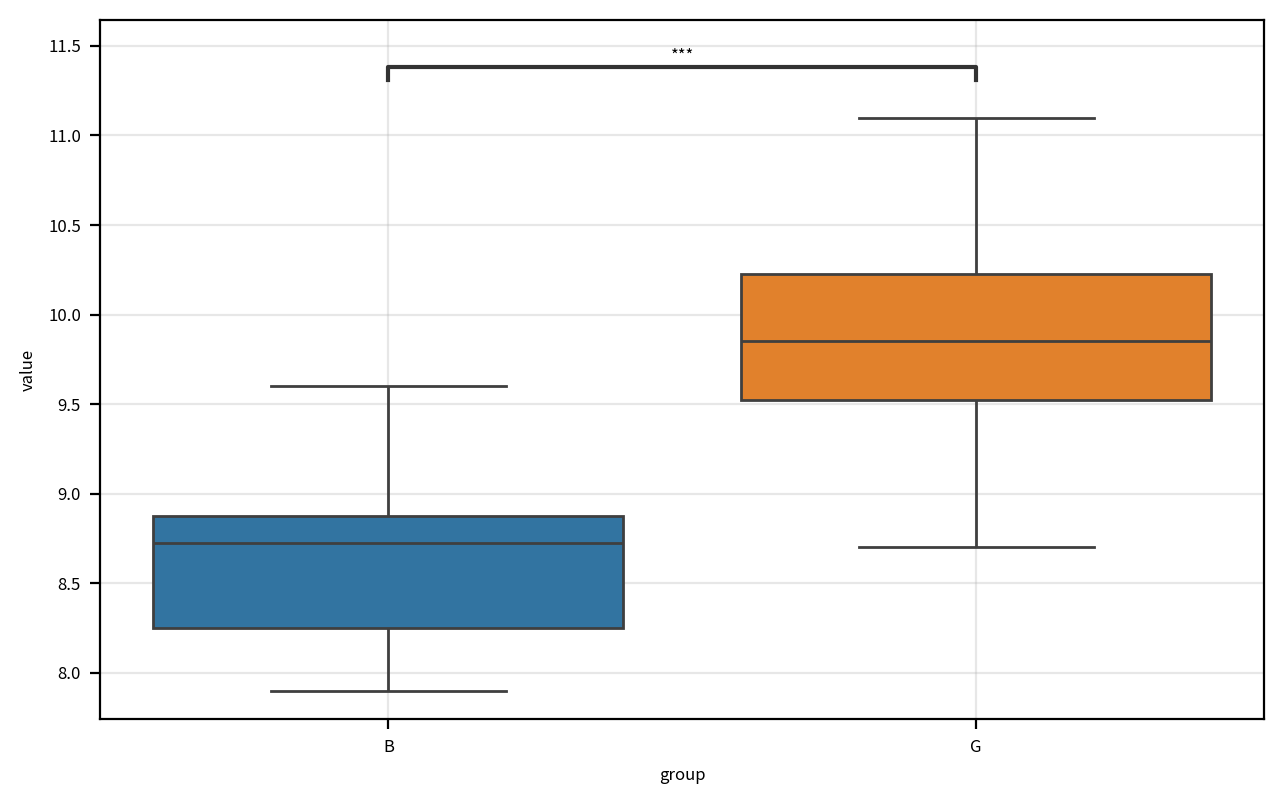

In [17]:
# 0) 데이터 전처리 (hue 쓰기 위해 melt로 재배치)
df = melt(origin, var_name='group', value_name='value') #✅: hue용
df

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 800             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) boxplot 그래프 그리기:
sb.boxplot(data = df, hue = 'group', x = 'group', y = 'value')

annotator = Annotator(ax, data=df, x = 'group', y = 'value',
                      pairs = [('B', 'G')])   # hue종류(pairs는 2차원임!)
annotator.configure(test = 't-test_ind')         # 환경설정
annotator.apply_and_annotate()                   # 적용 및 표시

# 3) 그래프 꾸미기: 
ax.grid(True, alpha=0.3)                # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()                      # 여백 제거
plt.show()                              # 그래프 화면 출력
plt.close()                             # 그래프 작업 종료

분석결과표에 p-value 표시할 때:

`p-value = 0.72 (p ≤ 0.05)` <=> `p-value = 0.72*` 같은말임!

**(`*` <- 표현은 파이썬만 가능!)**

## #03. 예제(2) - 인공심장 효과 측정

자료는 두 독립적인 그룹의 심장병 환자에 대한 심장계수(cardiac index)를 측정한 것이다.

그룹1은 심장수술을 받고 부착한 인공장기의 기능이 정상적인 사람들이고,

그룹2는 비정상으로 판명된 사람들이다.

심장계수는 수술 직후에 측정하였다.

목표: 이 두 그룹 환자에게 부착한 인공장기의 기능에 따라 심장계수가 서로 차이가 나는지 알아보는 것


### 1. 데이터 가져오기:

In [19]:
origin = load_data('heatrate')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/heatrate.xlsx
[desc] 두 독립적인 그룹의 심장병 환자에 대한 심장계수(cardiac index)를 측정한 데이터. `그룹1`은 심장수술을 받고 부착한 인공장기의 기능이 정상적인 사람들이고, `그룹2`는 비정상으로 판명된 사람들이다.심장계수는 수술 직후에 측정하였다. (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (8, 2)
열 갯수: 2
행 갯수: 8

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   그룹1     8 non-null      float64
 1   그룹2     8 non-null      float64
dtypes: float64(2)
memory usage: 260.0 bytes
None


,그룹1,그룹2
0,3.84,3.97
1,2.60,2.50
2,1.19,2.70
3,2.00,3.36
4,6.20,3.55


### 2. 신뢰구간 확인:

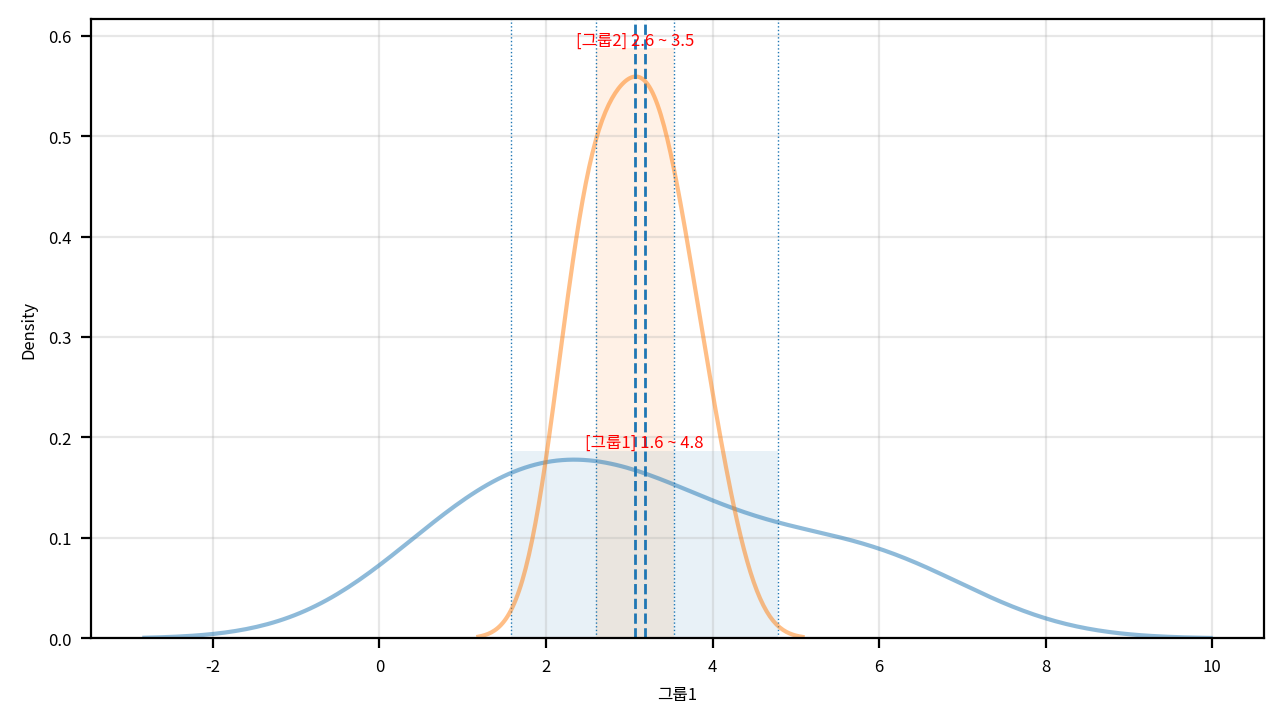

In [20]:
data = origin[['그룹1', '그룹2']]  # 확인할 데이터 (컬럼단위)

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for c in data.columns:
    # 2) KDE plot 그리기:
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 2-1) 신뢰구간용 기본변수:
    max = data[c].max()                        # 최대값
    dof = len(data[c]) - 1                     # 자유도
    clevel = 0.95                           # 신뢰수준
    sp_mean = data[c].mean()                   # 표본평균
    sp_std = data[c].std() # default: ddof=1   # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차

    # 2-2) 신뢰구간 x값:
    cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

    ax.axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
    ax.axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

    # 2-3) 신뢰구간 y값:
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    # 2-4) 평균선 표시:
    ax.axvline(sp_mean, linestyle="--", linewidth=1)

    # 2-5) 텍스트 그리기 (statAnnotator 기능):
    ax.text(x = cmin + (cmax-cmin)/2,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment = "center",
            verticalalignment = "bottom",
            fontdict = {"size": 6, "color": "red"})

# 3) 그래프 꾸미기: 
ax.grid(True, alpha=0.3)     # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료  

> 1. 두 그룹 다 커널밀도함수 모양이 정규분포
> 2. 데이터 분포는 서로 다름
> 3. 두 그룹 모두 표본평균이 신뢰구간 안에 존재하므로 두 그룹 다데이터는 정상범위에 있다

### 3. 가설검정의 가정 확인:

In [22]:
data = origin[['그룹1', '그룹2']]

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    s, p = normaltest(data[c])

    normalize = p > 0.05
    report.append({
        "fields": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize

# 변수가 두개 이상일 때 확인해야될 등분산성:
if len(data.columns) > 1:
    # 정규성 충족할 때 등분산성 검정방법:
    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*data.values.T) # 모든 컬럼의 데이터 한번에
    # 정규성 충족 못할 때 등분산성 검정법:
    else:
        n = "Levene's"
        s, p = levene(*data.values.T, center='median')
        # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨
    
    report.append({
        "fields": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
그룹1,0.839625,0.657170,True
그룹2,0.260764,0.877760,True
Bartlett,8.029088,0.004603,False


> 등분산성은 만족 못했네?

> 가설검정의 가정 중 하나에 해당하는 등분상성을 충족 못했더라도 `가설검정 시각화`를 수행하는 방법: `Welch's Test`

### 4. 두 그룹간 심장계수의 차이 있는지 검정:

등분산성 충족여부 파라미터: equal_var (기본값: True)
- if 등분산성에서 False: equal_var = False로 바꿔주기!
  - (∵ `statannotation`에선 `Welch's T-Test` 직접 지원하기 떄문에 등분산성 충족 못하더라도 시각화 가능)

이미 두 그룹간 평균 차이 없으니까 여기서 멈춰야 되는데 걍 코드 보여주려고 아래 서술한거임 (참고)

### 5. 그룹1의 심장계수가 그룹2의 심장계수보다 작은지 검정:

### 6. 그룹1의 심장계수가 그룹2의 심장계수보다 큰지 검정:

### 7. 가설검정 시각화: